## Summary: Credit card fraud detection

The data set is collected by the Machine Learning Group at Université Libre de Bruxelles and hosted on [Kaggle.com](https://www.kaggle.com/mlg-ulb/creditcardfraud). It contains the information on credit card transactions, the timing, and 28 principal components that provide the background information (due to confidentiality issues).

The data set is highly imbalanced: frauds account for only 0.17% of all transactions. As such, even though the data are labeled (fraud vs. non-fraud), I want to check if anomaly detection (unsupervised) algorithms can effectively detect the frauds or not.  In this regard, I compare the performances of Isolation Forest, Local Outlier Factor and Elliptic Envelope (similarly [here](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)). If frauds are truly outliers/anomalies, these algorithms should do well. However, they perform quite badly, suggesting that there can be distinctive patterns in the occurence of frauds. (The exploratory data analysis also indicates certain patterns in the fraudulent transactions.)

Since the anomaly detection techniques do not perform so well, I turn to the supervised-learning models to classify fraud transactions. To deal with the acute imbalance in the data, I implement the resampling techniques to re-balance the training data set. I compare the performances with under-sampling ([RandomUnderSampler](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html)) vs. with over-sampling ([SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)). The models with both resampling techniques perform equally well. But the under-sampling, which reduces the size of the training set, helps to fit the models much faster.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_roc_curve, accuracy_score, recall_score, make_scorer, classification_report

import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

sns.set()
pd.set_option('display.max_columns', None)

os.chdir("C:/Users/Nam/Desktop/Kaggle/creditcard_fraud_detection")

### Load data

In [2]:
df=pd.read_csv('creditcard.csv')
df['ln_amount']=df.Amount.apply(lambda x: np.log(x+0.001))

print('Fraction of being frauds: {:.2f}%'.format(df.Class.sum()/len(df)*100))

display(df.head())

display(df.info())
display(df[['Time','Amount']].describe())

Fraction of being frauds: 0.17%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ln_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.008105
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.989913
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.936641
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.816249
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.248367


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
Time         284807 non-null float64
V1           284807 non-null float64
V2           284807 non-null float64
V3           284807 non-null float64
V4           284807 non-null float64
V5           284807 non-null float64
V6           284807 non-null float64
V7           284807 non-null float64
V8           284807 non-null float64
V9           284807 non-null float64
V10          284807 non-null float64
V11          284807 non-null float64
V12          284807 non-null float64
V13          284807 non-null float64
V14          284807 non-null float64
V15          284807 non-null float64
V16          284807 non-null float64
V17          284807 non-null float64
V18          284807 non-null float64
V19          284807 non-null float64
V20          284807 non-null float64
V21          284807 non-null float64
V22          284807 non-null float64
V23          284807 non-null float64
V

None

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


### Correlation heatmaps

The 28 principal components are naturally not correlated with one another.

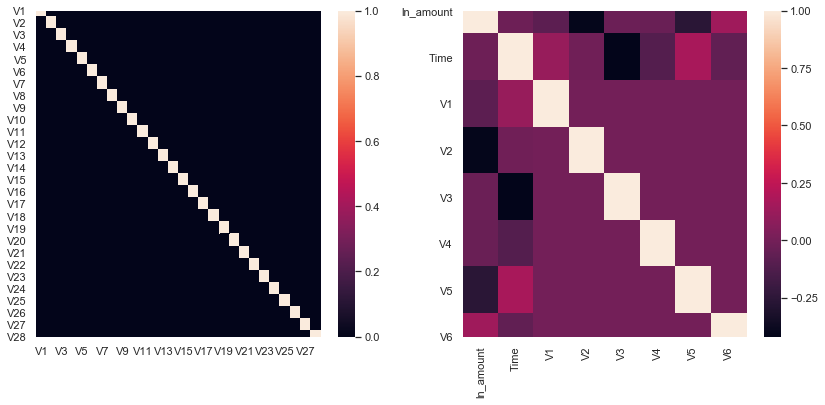

In [3]:
fig, ax= plt.subplots(1,2, figsize=(14,6))
sns.heatmap(ax=ax[0], data=df.filter(like='V').corr())
sns.heatmap(ax=ax[1], data=df[['ln_amount','Time','V1','V2','V3','V4','V5','V6']].corr())

### Exploratory Data Analysis

The graphs show that frauds do not seem to be outliers. There are systematic patterns. And the background data seem to do well in differentiating between frauds and legitimate transactions.

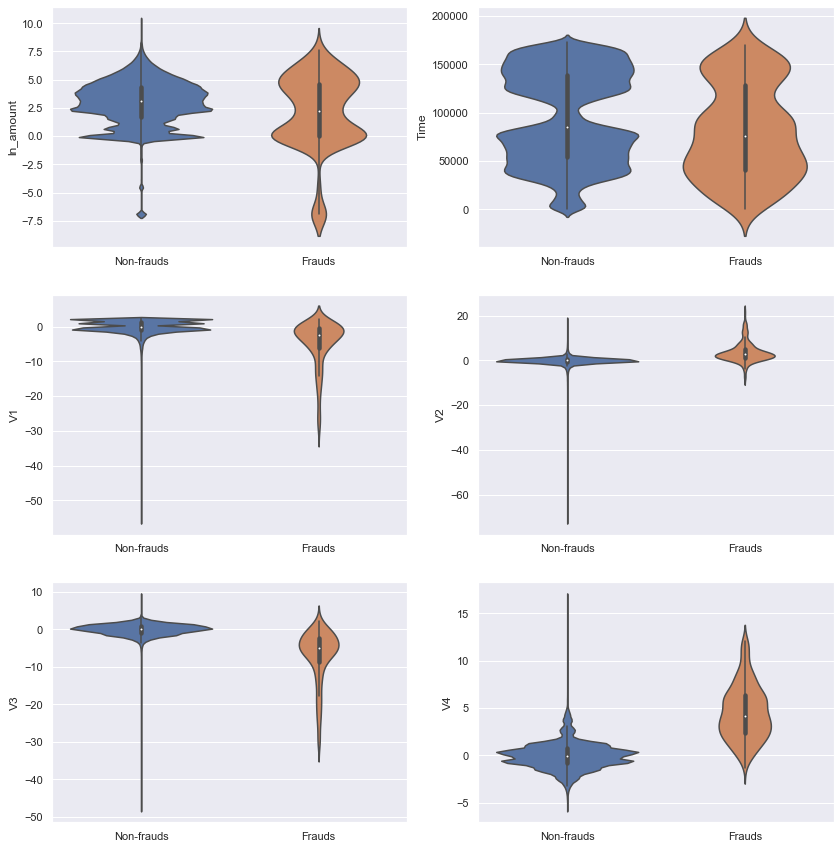

In [4]:
fig, ax = plt.subplots(3, 2, figsize=(14, 15))
for i, var in enumerate(['ln_amount','Time','V1','V2','V3','V4']):
    sns.violinplot(ax=ax[i//2, i%2], data=df, x='Class', y=var)
    ax[i//2,i%2].set_xticklabels(['Non-frauds','Frauds'])
    ax[i//2,i%2].set_xlabel('')

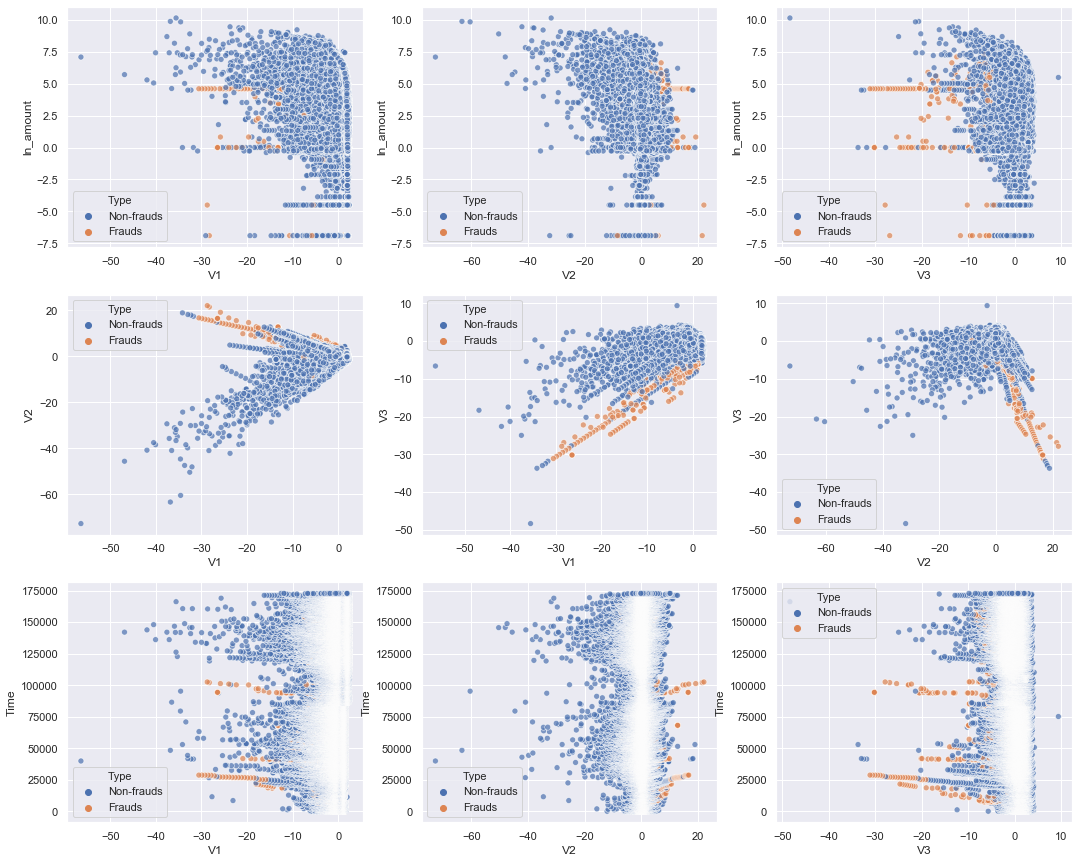

In [5]:
fig, ax= plt.subplots(3,3, figsize=(18, 15))
sns.scatterplot(ax=ax[0,0], data=df, x='V1', y='ln_amount', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[0,1], data=df, x='V2', y='ln_amount', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[0,2], data=df, x='V3', y='ln_amount', hue='Class', ci=None, alpha=0.7)

sns.scatterplot(ax=ax[1,0], data=df, x='V1', y='V2', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[1,1], data=df, x='V1', y='V3', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[1,2], data=df, x='V2', y='V3', hue='Class', ci=None, alpha=0.7)

sns.scatterplot(ax=ax[2,0], data=df, x='V1', y='Time', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[2,1], data=df, x='V2', y='Time', hue='Class', ci=None, alpha=0.7)
sns.scatterplot(ax=ax[2,2], data=df, x='V3', y='Time', hue='Class', ci=None, alpha=0.7)

for i in [0,1,2]:
    for j in [0,1,2]:
        ax[i,j].get_legend().texts[0].set_text('Type')
        ax[i,j].get_legend().texts[1].set_text('Non-frauds')
        ax[i,j].get_legend().texts[2].set_text('Frauds')

### Anomaly detection

Even though the EDA indicates that frauds are not mere outliers/anomalies, I want to check the performances of the unsupervised anomaly detection techniques. Here, I compare the algorithms [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html), [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) and [Elliptic Envelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html). All models perform poorly (with Isolation Forest being slightly better) in terms of both the recall score and the execution time.

In [6]:
df[['ln_amount','Time']]=df[['ln_amount','Time']].apply(preprocessing.scale)

X=np.array(df)[:,:-1]
y=np.array(df.Class)
outlier_fraction=np.sum(y)/len(y)

models=dict({"IsoForest":IsolationForest(n_estimators=100, contamination=outlier_fraction, random_state=0),\
             "LOF":LocalOutlierFactor(n_neighbors=20, contamination=outlier_fraction),\
             "Envelope":EllipticEnvelope(contamination=outlier_fraction, random_state=0)
            # "SVM":OneClassSVM(kernel='rbf')
            })
    
for mod in models.keys():
    start=time.clock()
    y_pred=models[mod].fit_predict(X)<0
    print('Recall score of {}: {:.2f}'.format(mod, recall_score(y, y_pred)))
    print('Runtime of {}: {:.2f} \n'.format(mod, time.clock()-start))

Recall score of IsoForest: 0.23
Runtime of IsoForest: 43.06 

Recall score of LOF: 0.07
Runtime of LOF: 547.37 

Recall score of Envelope: 0.03
Runtime of Envelope: 32.17 



### Classification with under-sampling

Here, I compare the performances of the (supervised-learning) models K-nearest neighbors, Support Vector Machine, Logistic Reg, Decision Tree, Random Forest and Extreme Gradient Boosting. To deal with the imbalanced data (with low occurence of frauds), I resample the training data with RandomUnderSampler. Decision Tree and Extreme Gradient Boosting are the best performers. But Extreme Gradient Boosting takes the longest time to fit the model.

Text(0.5, 1.0, 'Runtime')

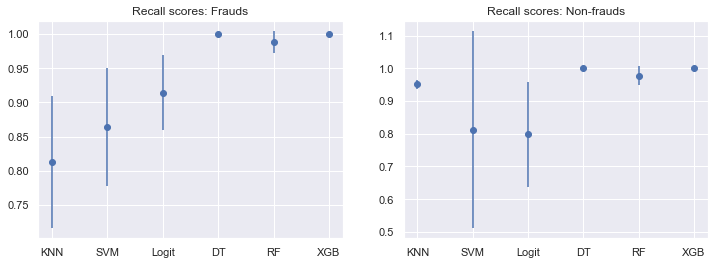

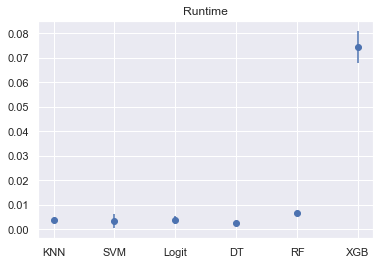

In [7]:
scores_positive=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])
scores_negative=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])
timetab=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])

models=dict({'KNN':KNeighborsClassifier(),\
             'SVM':SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3),\
            'Logit':SGDClassifier(loss='log', max_iter=1000, tol=1e-3),\
            'DT':DecisionTreeClassifier(),\
            'RF':RandomForestClassifier(n_estimators=3),\
            'XGB':xgb.XGBClassifier(n_estimators=100)})

kfold=KFold(n_splits=5)
j=0
for i_train, i_test in kfold.split(np.c_[y]):
    X_train, y_train = RandomUnderSampler('majority').fit_resample(X[i_train,:], y[i_train])
    X_test, y_test = X[i_test,:], y[i_test]
    
    for mod in models.keys():
        start=time.clock()
        models[mod].fit(X_train, y_train)
        timetab[mod].loc[j]=time.clock()-start
    
    X_pos=X_test[y_test>0,:]
    y_pos=y_test[y_test>0]
    X_neg=X_test[y_test==0,:]
    y_neg=y_test[y_test==0]
    
    scores_positive.loc[j]=[accuracy_score(y_pos, models[mod].predict(X_pos)) for mod in models.keys()]
    scores_negative.loc[j]=[accuracy_score(y_neg, models[mod].predict(X_neg)) for mod in models.keys()]
    j+=1

fig=plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.errorbar(x=scores_positive.columns.values, y=scores_positive.mean(), yerr=scores_positive.std(), fmt='o')
fig.add_subplot(1,2,2)
plt.errorbar(x=scores_negative.columns.values, y=scores_negative.mean(), yerr=scores_negative.std(), fmt='o')
fig.axes[0].set_title('Recall scores: Frauds')
fig.axes[1].set_title('Recall scores: Non-frauds')
fig.show()

plt.figure(figsize=(6,4))
plt.errorbar(x=timetab.columns.values, y=timetab.mean(), yerr=timetab.std(), fmt='o')
plt.title('Runtime')

### Classification with over-sampling

I now over-sample the training data with SMOTE. Decision Tree and Extreme Gradient Boosting again perform the best in terms of recall scores. However, over-sampling clearly results in much longer execution time than under-sampling (which is intuitive, since under-sampling reduces the size of the training set).

Text(0.5, 1.0, 'Runtime')

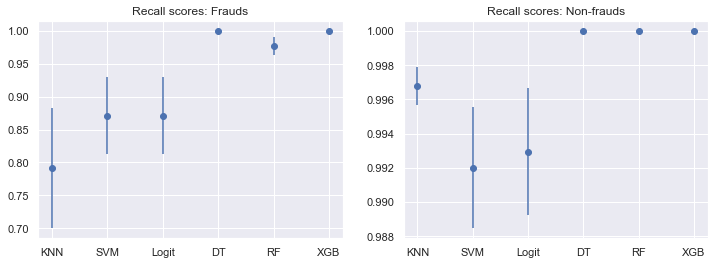

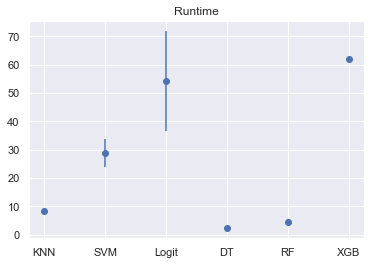

In [8]:
scores_positive=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])
scores_negative=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])
timetab=pd.DataFrame(index=range(5), columns=['KNN','SVM','Logit','DT','RF','XGB'])

models=dict({'KNN':KNeighborsClassifier(),\
             'SVM':SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3),\
            'Logit':SGDClassifier(loss='log', max_iter=1000, tol=1e-3),\
            'DT':DecisionTreeClassifier(),\
            'RF':RandomForestClassifier(n_estimators=3),\
            'XGB':xgb.XGBClassifier(n_estimators=100)})

kfold=KFold(n_splits=5)
j=0
for i_train, i_test in kfold.split(np.c_[y]):
    X_train, y_train = SMOTE('minority').fit_resample(X[i_train,:], y[i_train])
    X_test, y_test = X[i_test,:], y[i_test]
    
    for mod in models.keys():
        start=time.clock()
        models[mod].fit(X_train, y_train)
        timetab[mod].loc[j]=time.clock()-start
    
    X_pos=X_test[y_test>0,:]
    y_pos=y_test[y_test>0]
    X_neg=X_test[y_test==0,:]
    y_neg=y_test[y_test==0]
    
    scores_positive.loc[j]=[accuracy_score(y_pos, models[mod].predict(X_pos)) for mod in models.keys()]
    scores_negative.loc[j]=[accuracy_score(y_neg, models[mod].predict(X_neg)) for mod in models.keys()]
    j+=1

fig=plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.errorbar(x=scores_positive.columns.values, y=scores_positive.mean(), yerr=scores_positive.std(), fmt='o')
fig.add_subplot(1,2,2)
plt.errorbar(x=scores_negative.columns.values, y=scores_negative.mean(), yerr=scores_negative.std(), fmt='o')
fig.axes[0].set_title('Recall scores: Frauds')
fig.axes[1].set_title('Recall scores: Non-frauds')
fig.show()

plt.figure(figsize=(6,4))
plt.errorbar(x=timetab.columns.values, y=timetab.mean(), yerr=timetab.std(), fmt='o')
plt.title('Runtime')